# Deepfake Project

### Imports

In [ ]:
import tensorflow as tf
import numpy as np

np.random.seed(30)
tf.random.set_seed(30)

In [ ]:
# Install Lime
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d5c1e0fec88ea688dec7341cd18da2ba8870a1c98c3c200dd15f5168347ff502
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade tensorflow keras


In [ ]:
from scikeras.wrappers import KerasClassifier

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=10, verbose=1)

In [ ]:
# Regular Imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
matplotlib.rc_file_defaults()
%matplotlib inline

# Keras Stuff
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D, Embedding
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

# Sklearn Stuff
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

# Lime
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb

In [ ]:
# Checking the ram usage

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('This runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('This notebook is using a high level of RAM.')

This runtime has 359.2 gigabytes of available RAM

This notebook is using a high level of RAM.



### Functions


In [ ]:
# An assortment of functions found in this notebook will be featured in this cell.

def print_dir_contents(fpath = None):
    '''Prints the contents of a provided filepath.  Default is current directory.

    Args:
        fpath (str): File path of directory.

    Returns:
        Print of contents of folder
    '''

  if fpath is None:
    fpath = os.path.abspath(os.curdir)

  print(f"Contents of Folder: '{fpath}':")
  files = sorted(os.listdir(fpath))
  tab = '\n\t'
  print('\t' + tab.join(files))


def get_number_images(folder_type, folders = ['fake','real'], verbose = False):
    '''Gets the total number of images for all folders of images.

    Args:
        folder_type (str): Image folder you want to calculate.
        folders (list): Folders within folder_type.  Default = ['fake', 'real']
        verbose (bool): Print output.  Default = False

    Returns:
        Number of images.

    '''
  num_images = 0
  for folder in folders:
    num_in_folder = len(os.listdir(folder_type + folder))

    if verbose:
      print('There are {} images in {} folder.'.format(num_in_folder, folder))
    num_images += num_in_folder

  return num_images


def count_plot(df, column):
    '''Plots a countplot after taking in a dataframe and column.

    Args:
        df (str): Dataframe for plotting.
        column (str): Column for plotting.

    Returns:
        Count plot

    '''

    # Setting style for plots
    sns.set(font_scale = 1.25)
    sns.set_style('dark')

    # Plotting barplot
    fig, ax = plt.subplots(figsize = (8, 4))
    ax = sns.countplot(data = df, x = column, ax = ax)
    ax.set_title('Number of Images by {}'.format(column.split('_')[0].title()))
    ax.set_xlabel(column.split('_')[0].title())
    ax.set_ylabel('Count');

    return fig



def evaluate_classifier(model, X_test, y_test):
    '''Evaluates a classification model by displaying a classification report,
    a confusion matrix plot, and a ROC-AUC plot.

    Args:
        model (str): Model you want to evaluate.
        X_test (str): Test set for evaluation.
        y_test (str): Test labels for evaluation.

    Returns:
        Classification Report
        Confusion Matrix
        ROC-AUC Curve
    '''

    # Predictions
    y_hat_test = model.predict(X_test)

    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))

    # Confusion Matrix Plot
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true', cmap = 'Blues', ax = axes[0])
    axes[0].set_title('Confusion Matrix');

    # ROC-AUC Curve
    roc__auc_plot = plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show()


def network_eval_plots(results):
    '''Visualizes the loss and accuracy of the training set and validation set.

    Args:
        results (str): Output of a neural network, either Pandas dataframe or Tensorflow history.

    Returns:
        Plots for loss and accuracy curves.
    '''
    if isinstance(results, pd.DataFrame):
        data = results
    else:
        data = results.history


    plt.figure()
    plt.plot(data['val_loss'])
    plt.plot(data['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(data['val_acc'])
    plt.plot(data['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


def nn_confusion_matrix(y_test, preds):
    '''Creates a confusion matrix specifically for neural networks.

    Args:
        y_test (str): Labels for test set
        preds (str): Model predictions

    Returns:
        Confusion Matrix

    '''
    labels = ['Real', 'Fake']
    cm = confusion_matrix(y_test, preds, normalize = 'true')
    ax = plt.figure(figsize = (6,6))
    ax = sns.heatmap(cm, cmap = 'Blues', annot = True, xticklabels = ['Fake', 'Real'],
                     yticklabels = ['Fake', 'Real']) # pass in a list for xtick labels
    ax.set_ylim([0,2])


def evaluate_network(results, model, X_test, y_test):
    '''Simple function to evaluate neural networks as well as models that are saved and then loaded in from colab.

    Args:
        results (str): Output of the model, either pandas Dataframe or Tensorflow history.
        model (str): Model you want to evaluate.
        X_test (str): Test set.
        y_test (str): Test labels.

    Returns:
        Model Evaluation
        Loss & Accuracy Curves
        Classification Report
        Confusion Matrix

    '''

    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    dashes = '-------------------------------------------------------' # save dashes as variable instead of this
    print(dashes)
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print(dashes)
    network_eval_plots(results)
    print(' ')
    print('                 Classification Report')
    print(dashes)
    print(classification_report(y_test, preds, target_names = ['Fake', 'Real']))
    print(' ')
    print('                 Confusion Matrix')
    print(dashes)
    nn_confusion_matrix(y_test, preds)


def test_single_image(test_file_path, model, image_class):
    ''' Test a single image to see if the model is properly predicting.
        Image class is either 1 or 0.

    Args:
        test_file_path (str): File path for the image you want to test.
        model (str): Model you want to test.
        image_class: Presumed label for the image you want to test.

    Returns:
        Model prediction of single image input.

    '''

    test_img = image.load_img(test_file_path, target_size= (64, 64))
    test_tensor = image.img_to_array(test_img)
    test_tensor = test_tensor.reshape(1, 64, 64, 3)
    test_tensor /= 255.

    # Get prediction
    test_pred = model.predict(test_tensor).round()

    # Output
    print('The true class of this image is: ', img_class)
    print('The predicted class of this images is: ', test_pred)


def test_single_image_ensemble(test_file_path, model, image_class):
    ''' Test a single image to see if the model is properly predicting.
        Image class is either 1 or 0.  Uses an extra processing step for use with ensemble network.

    Args:
        test_file_path (str): File path for the image you want to test.
        model (str): Model you want to test.
        image_class: Presumed label for the image you want to test.

    Returns:
        Model prediction of single image input.

    '''

    test_img = image.load_img(test_file_path, target_size= (64, 64))
    test_tensor = image.img_to_array(test_img)
    test_tensor = test_tensor.reshape(1, 64, 64, 3)
    test_tensor /= 255.
    test_tensor = [test_tensor for _ in range(64)]

    # Get prediction
    test_pred = model.predict(test_tensor).round()

    # Output
    print('The true class of this image is: ', img_class)
    print('The predicted class of this images is: ', test_pred)


def lime_explainer_image(image_from_test_set, image_label):
    '''Sets up lime explainer and also will display explanation images.
     Image must be in the format of dataset[slice] as in X_test[0].
     Image can be any sliced image from test set.
     Image label is y_test[0] or y_test[1]

     Args:
        image_from_test_set (str): Sliced entry from test set.  Example: X_test[12]
        image_label (str):  Presumed image label.

    Returns:
        Lime Explainer Image

    '''

    # Message
    print('This may take a few minutes...')

    # Create explainer
    explainer = lime_image.LimeImageExplainer(verbose = False)
    segmenter = SegmentationAlgorithm('slic', n_segments = 100, compactness = 1, sigma = 1)

    # Set up the explainer
    new_explanation = explainer.explain_instance(image_from_test_set, classifier_fn= pt_network_updated,
                                             top_labels = 2, hide_color = 0, num_samples = 1000,
                                             segmentation_fn = segmenter)

    # Plot the explainer
    temp, mask = new_explanation.get_image_and_mask(image_label, positive_only=True, num_features=5, hide_rest=False)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.axis('off')
    ax1.set_title('Positive Regions for {}'.format(image_label))
    temp, mask = new_explanation.get_image_and_mask(image_label, positive_only=False, num_features=10, hide_rest=False)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.axis('off')
    ax2.set_title('Positive & Negative Regions for {}'.format(image_label));

## 2. Obtain

> The dataset used int his project was created by combining the contents of of several datasets of faces from Kaggle.  After a rather exhaustive search to find datasets with images of similar quality, we settled using a random combination of images from here, here & here.  Once imported, he dataset was split into a training set, test set, and validation set totaling 142, 286 images, nearly equally distributed between "real" and "fake".


### Importing Dataset from Google Drive

>In order to import the dataset from Google Drive, we first need to mount the drive and then add & unzip the dataset into this notebook.  

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [ ]:
# Getting current directory and contents
print(os.getcwd())
print(os.listdir())

/content
['.config', 'sample_data']


In [ ]:
# Changing the directory to the parent folder
os.chdir('../')
print(os.getcwd())
print(os.listdir())

/
['boot', 'sys', 'root', 'mnt', 'opt', 'lib64', 'tmp', 'bin', 'lib', 'dev', 'sbin', 'proc', 'srv', 'usr', 'run', 'etc', 'home', 'media', 'var', 'gdrive', '.dockerenv', 'tools', 'datalab', 'swift', 'content', 'tensorflow-1.15.2', 'lib32']


In [ ]:
# Function to print the file path
def print_path(return_ = False):
  '''Prints the current directory.'''
  path = os.path.abspath(os.curdir)
  print('Current Directory = ', path)
  if return_:
    return path

print_path(return_ = True)

Current Directory =  /


'/'

In [ ]:
# Checking out the contesnts of the directory.

print_dir_contents()

Contents of Folder: '/':
	.dockerenv
	bin
	boot
	content
	datalab
	dev
	etc
	gdrive
	home
	lib
	lib32
	lib64
	libx32
	media
	mnt
	opt
	proc
	python-apt
	python-apt.tar.xz
	root
	run
	sbin
	srv
	sys
	tmp
	tools
	usr
	var


In [ ]:
# Getting to the source folder

source_folder = r'/gdrive/My Drive/Dataset'
print_dir_contents(source_folder)

Contents of Folder: '/gdrive/My Drive/Dataset':
	dataset.zip
	dataset1.zip


In [ ]:
# Setting zip path and filename

zip_path = '/gdrive/My Drive/Dataset/dataset1.zip'
fname = 'dataset1.zip'

In [ ]:
# Setting zip path and filename

zip_path = '/gdrive/My Drive/Datasets-2/Deepfake-images V2.zip'
fname = 'Deepfake-images V2.zip'

In [ ]:
!cp "{zip_path}" .
!unzip -q "{fname}"
!rm "{fname}"

In [ ]:

# Looks like our data is now mounted

print_dir_contents()

Contents of Folder: '/':
	.dockerenv
	Dataset
	NGC-DL-CONTAINER-LICENSE
	bin
	boot
	content
	cuda-keyring_1.0-1_all.deb
	datalab
	dev
	etc
	gdrive
	home
	lib
	lib32
	lib64
	libx32
	media
	mnt
	opt
	proc
	python-apt
	python-apt.tar.xz
	root
	run
	sbin
	srv
	sys
	tmp
	tools
	usr
	var


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Scrub


> In order to be able to feed our dataset of images into the models, we first need to convert the images into arrays and then split the images into test, train, validation sets.

### Prepping the Data with ImageDataGenerator

In [ ]:

# Defining a base folder & checking contents

base_folder = '/Dataset'

print_dir_contents(base_folder)

Contents of Folder: '/Dataset':
	Test
	Train
	Validation


In [ ]:
# Define the train, test and validation folders
train_folder = base_folder + '/Train/'
test_folder = base_folder + '/Test/'
validation_folder = base_folder + '/Validation/'

# Checking train folder contents
print_dir_contents(train_folder)
print_dir_contents(test_folder)
print_dir_contents(validation_folder)

Contents of Folder: '/Dataset/Train/':
	Fake
	Real
Contents of Folder: '/Dataset/Test/':
	Fake
	Real
Contents of Folder: '/Dataset/Validation/':
	Fake
	Real


In [ ]:
# See number of images in each folder

print('Train Folder')
print('---------------')
num_train_images = get_number_images(train_folder, folders=['Fake', 'Real'], verbose=True)
print(' ')

print('Test Folder')
print('---------------')
num_test_images = get_number_images(test_folder, folders=['Fake', 'Real'], verbose=True)
print(' ')

print('Validation Folder')
print('-----------------')
num_val_images = get_number_images(validation_folder, folders=['Fake', 'Real'], verbose=True)

Train Folder
---------------
There are 70001 images in Fake folder.
There are 70001 images in Real folder.
 
Test Folder
---------------
There are 5492 images in Fake folder.
There are 5413 images in Real folder.
 
Validation Folder
-----------------
There are 19641 images in Fake folder.
There are 19787 images in Real folder.


> Below, we'll use the ImageDataGenerator to rescale and resize each image.

In [ ]:
# Get all data from each folder and reshape them.  Tried 128, 96 and 64 square pixels.

training_set = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder,
                                                           target_size = (64, 64),
                                                           class_mode = 'binary',
                                                           batch_size = num_train_images)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                          target_size = (64, 64),
                                                          class_mode = 'binary',
                                                          batch_size = num_test_images)

val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_folder,
                                                         target_size = (64, 64),
                                                         class_mode = 'binary',
                                                         batch_size = num_val_images)


Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [ ]:
# Creating actual datasets

X_train, y_train = next(training_set)
X_test, y_test = next(test_set)
val_x, val_y = next(val_set)

In [ ]:
X_train[0].shape

(64, 64, 3)

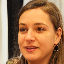

In [ ]:
# Checking train set

array_to_img(X_train[0])

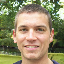

In [ ]:
# Checking test set

array_to_img(X_test[0])

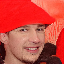

In [ ]:
# Checking validation set

array_to_img(val_x[0])

In [ ]:
# Checking out what the classes are, numerically

print(training_set.class_indices)
print(test_set.class_indices)
print(val_set.class_indices)

{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}


In [ ]:

# Checking the shape of X_train out of curiosity

X_train.shape

(140002, 64, 64, 3)

In [ ]:

# Checking out the final numbers after scrubbing

m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]
m_val = val_x.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(X_train.shape))
print ("train_labels shape: " + str(y_train.shape))
print ("test_images shape: " + str(X_test.shape))
print ("test_labels shape: " + str(y_test.shape))
print ("val_images shape: " + str(val_x.shape))
print ("val_labels shape: " + str(val_y.shape))

Number of training samples: 140002
Number of testing samples: 10905
Number of validation samples: 39428
train_images shape: (140002, 64, 64, 3)
train_labels shape: (140002,)
test_images shape: (10905, 64, 64, 3)
test_labels shape: (10905,)
val_images shape: (39428, 64, 64, 3)
val_labels shape: (39428,)


## 4. Explore

#### Count Plot of Classes

> Below, we can plot the class balance of the training, test, and validation sets.

In [ ]:
# Create dataframes of the classes for easier plotting

y_train_df = pd.DataFrame(y_train, columns = ['Class'])
y_test_df = pd.DataFrame(y_test, columns = ['Class'])
val_y_df = pd.DataFrame(val_y, columns = ['Class'])

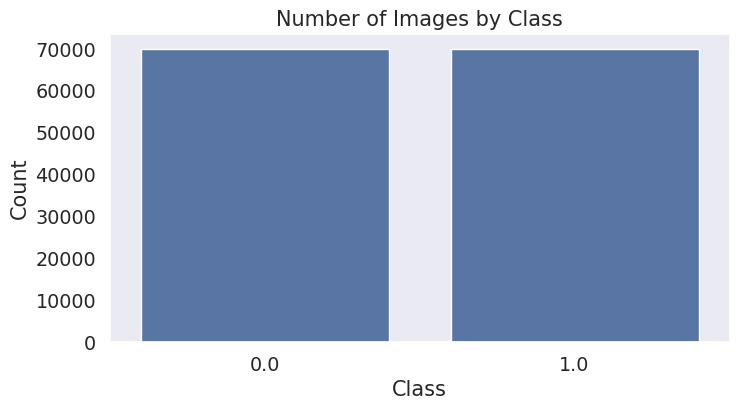

In [ ]:

# Count plot of training set
fig = count_plot(y_train_df, 'Class')

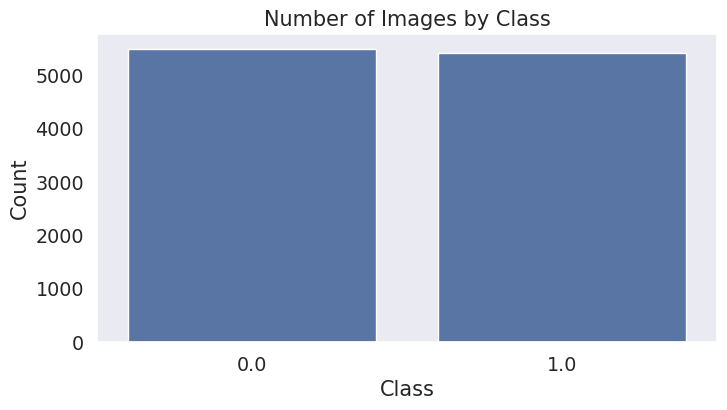

In [ ]:

# Count plot of test set
count_plot(y_test_df, 'Class');

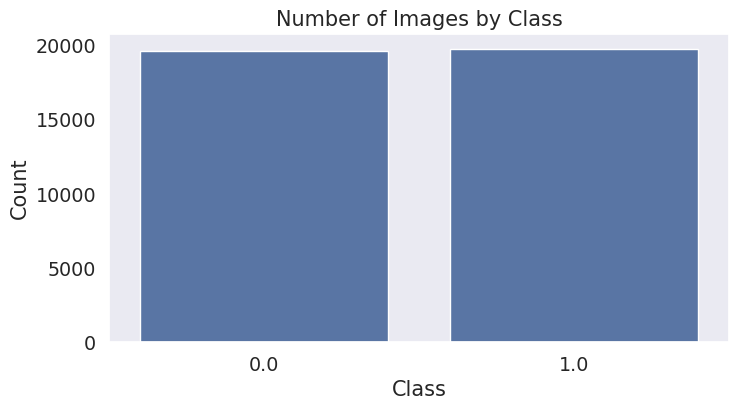

In [ ]:

# Count plot of validation set
count_plot(val_y_df, 'Class');

#### Image Resolution

> Here, we can see the difference in resolution between an original image from the dataset and the same image after going through the preprocessing.

In [ ]:
def display_single_image(img_path, img_size, print_shape = False):
  '''Displays an image, and depending on need, can print the input shape'''

  # Load Image
  img = image.load_img(img_path, target_size= img_size)
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)

  # Light preprocessing
  img_tensor /= 255.

  # Print the shape
  if print_shape:
    print(img_tensor.shape)

  # Display the image
  plt.imshow(img_tensor[0])
  plt.axis('off')
  plt.show()

In [ ]:

# Attemtpting to reset an annoying Seaborn style that won't go away.
sns.reset_orig


<function seaborn.rcmod.reset_orig()>

     Original Image Resolution
----------------------------------
(1, 256, 256, 3)


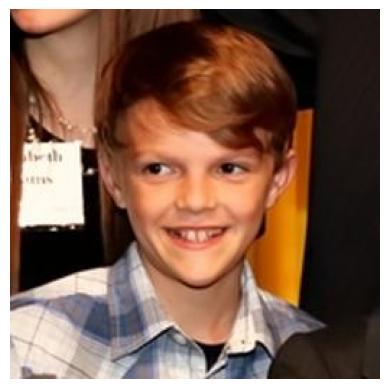

  Resolution After Preprocessing
----------------------------------
(1, 64, 64, 3)


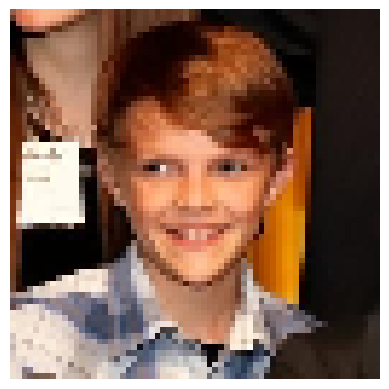

In [ ]:
# Comparing the resolutions of our original images and our process images.

img_path = '/Dataset/Train/Real/real_201.jpg'
img_size = (256, 256)
img_size2 = (64, 64)

print("     Original Image Resolution")
print('----------------------------------')
display_single_image(img_path, img_size, print_shape = True)

print("  Resolution After Preprocessing")
print('----------------------------------')
display_single_image(img_path, img_size2, print_shape = True)

            Real Image
----------------------------------



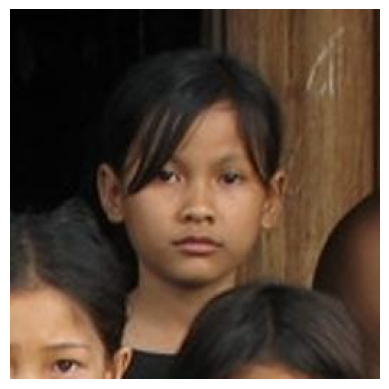


            Fake Image
----------------------------------



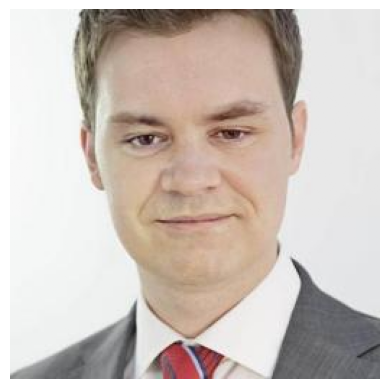

In [ ]:

# Set Image Paths
real_img_path = '/Dataset/Train/Real/real_111.jpg'
fake_img_path = '/Dataset/Train/Fake/fake_196.jpg'

# Set Images Sizes
img_size_orig = (256, 256)

# Display Images
print("            Real Image")
print('----------------------------------\n')
display_single_image(real_img_path, img_size_orig)
print('')

print("            Fake Image")
print('----------------------------------\n')
display_single_image(fake_img_path, img_size_orig)

#### Real Image vs. Fake Image

> We were curious to see if there was going to be an obvious difference between a real image and a fake image.  We've plotted one of each below and we can see that it's very difficult to tell which is the deepfake without labeling.

## 5. Model

> After preprocessing the images, we embarked on an EXHAUSTIVE journey of modeling the data.  Convolutional Neural Networks are regarded as the go-to model for computer vision tasks, so we decided to experiment with several different methods of implementing CNN's.  

> Below, you will find the model architecture and results from a simple, baseline CNN, a CNN that was tuned through a lengthy process of trial and error, a CNN using a pretrained model (Xception), and an ensemble model combining the architectures of the tuned CNN and pretrained CNN.

### Baseline CNN

> The first model we experimented with is just a simple baseline CNN.  Here, we used two small neuron Conv2D layers that are fed into a single Dense output layer.  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3137      
Total params: 8,657
Trainable params: 8,657
Non-trainable params: 0
______________________________________________________

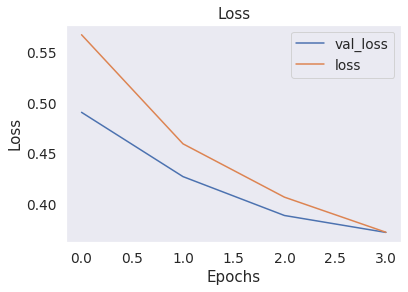

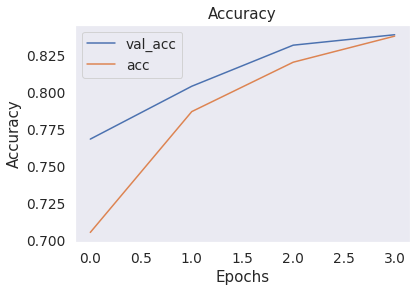

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.76      0.82      0.79     10480
        Real       0.80      0.74      0.77     10270

    accuracy                           0.78     20750
   macro avg       0.78      0.78      0.78     20750
weighted avg       0.78      0.78      0.78     20750

 
                 Confusion Matrix
-------------------------------------------------------


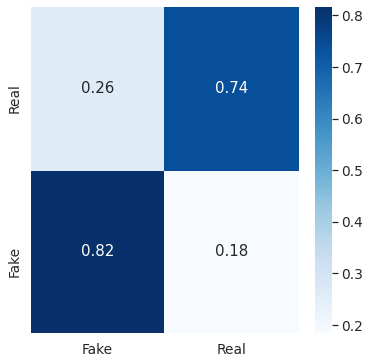

In [ ]:
# Early Stopping
callback = EarlyStopping(monitor = 'val_acc', patience = 3, mode = 'max',
                         min_delta = .1, restore_best_weights = True)

# Create base neural network
baseline_model = Sequential()

# Hidden Layers
baseline_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (64, 64, 3)))
baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Conv2D(16, (3, 3), activation = 'relu'))
baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Flatten())

# Output Layer
baseline_model.add(Dense(1, activation = 'sigmoid'))

# Compile Model
baseline_model.compile(optimizer = 'RMSProp', loss = 'binary_crossentropy',
              metrics = ['acc'])

# Get the model summary
print(baseline_model.summary())

# Fit Model
history = baseline_model.fit(X_train, y_train, batch_size = 64, epochs = 25,
                    validation_data = (val_x, val_y), callbacks = callback)

# Evaluating the model
evaluate_network(history, baseline_model, X_test, y_test)

> Our baseline model performed admirably, but we definitely want to achieve a much higher level of accuracy for a proper deepfake detection app.  Luckily, we can do a bunch of parameter tuning in order to make this model MUCH more accurate.






### CNN with Parameter Tuning

> In this model, we expanded the architecture to include several more Conv2D and Dense layers, as well as several layers of BatchNormalization to prevent serious ovefitting.  

> In the interest of saving time, we saved the final iteration of this model so it didn't need to train every single time.  You can find the model architecture below and then the results produced from the saved model after that.

#### Model Architecture

``` python
# Early Stopping
callback = EarlyStopping(monitor = 'val_acc', patience = 3, mode = 'max',
                         min_delta = .01, restore_best_weights = True)

# Create base neural network
model_2 = Sequential()

# Hidden Layers
model_2.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (64, 64, 3)))
model_2.add(BatchNormalization(momentum=0.95,
          epsilon=0.005))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(64, (3, 3), activation = 'tanh'))
model_2.add(BatchNormalization(momentum=0.95,
          epsilon=0.005))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(32, (3, 3), activation = 'tanh'))
model_2.add(BatchNormalization(momentum=0.95,
          epsilon=0.005))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(16, (3, 3), activation = 'tanh'))
model_2.add(BatchNormalization(momentum=0.95,
          epsilon=0.005))
model_2.add(MaxPooling2D((2, 2)))

# Flatten
model_2.add(Flatten())

# Dense Layers
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dense(32, activation = 'relu'))

# Output Layer
model_2.add(Dense(1, activation = 'sigmoid'))

# Compile Model
model_2.compile(optimizer = 'sgd', loss = 'binary_crossentropy',
              metrics = ['acc'])

# Get the model summary
print(model_2.summary())

# Fit Model
history_2 = model_2.fit(X_train, y_train, batch_size = 16, epochs = 25,
                    validation_data = (val_x, val_y), callbacks = callback,
                    workers = 16)

# Evaluating the model
evaluate_network(history_2, model_2, X_test, y_test)
```

#### Saved Tuned Convolutional Neural Network

In [ ]:
# Saving the current version of the model for later.
drive.mount('/gdrive', force_remount = True)
model_2.save('/gdrive/MyDrive/TrueSight/updated_tuned_nn.keras')

In [ ]:
# Saving history as a dataframe...as a csv

#tuned_hist_df = pd.DataFrame(history_2.history)
#drive.mount('/gdrive', force_remount = True)
#tuned_hist_df.to_csv('tuned_dataframe.csv')
#!cp tuned_dataframe.csv "gdrive/My Drive/Capstone Dataframes"

In [ ]:
tuned_hist_df = pd.DataFrame(history_2.history)
drive.mount('/gdrive', force_remount = True)
tuned_hist_df.to_csv('tuned_dataframe.csv')
!cp tuned_dataframe.csv "/gdrive/MyDrive/TrueSight"

Mounted at /gdrive


##### Load & Evaluate Model

Mounted at /gdrive
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1

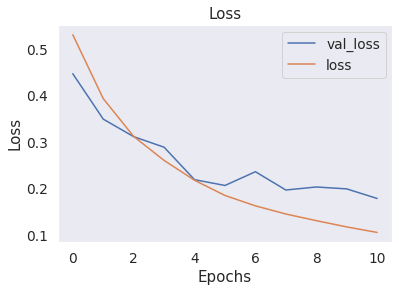

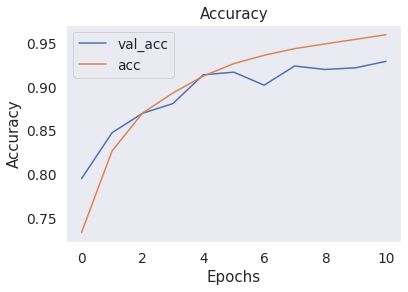

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.92      0.93      0.92     10480
        Real       0.92      0.92      0.92     10270

    accuracy                           0.92     20750
   macro avg       0.92      0.92      0.92     20750
weighted avg       0.92      0.92      0.92     20750

 
                 Confusion Matrix
-------------------------------------------------------


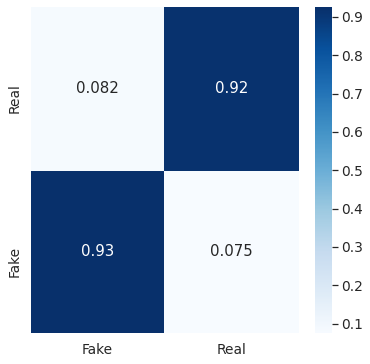

In [ ]:
# Mount google drive again
drive.mount('/gdrive', force_remount = True)

# Loading the ensemble model
tuned_nn_updated = tf.keras.models.load_model('/gdrive/MyDrive/TrueSight/updated_tuned_nn.keras')

# Loading the model history
history_path = 'gdrive/My Drive/TrueSight/tuned_dataframe.csv'
tuned_hist_df = pd.read_csv(history_path)

# Checking the summary
tuned_nn_updated.summary()

# Evaluate the model
evaluate_network(tuned_hist_df, tuned_nn_updated, X_test, y_test)

> The accuracy of this model is much better than the baseline CNN as it has now cracked 90% with an almost equal recall.  For the purposes of this project, recall is an important metric as we'd rather have a false positive than a false negative.

#### Testing with Validation Set

> To make sure that we're definitely getting an accurate picture of how the model is performing, we can test it specifically against the validation set.

              precision    recall  f1-score   support

        Fake       0.92      0.91      0.92     10480
        Real       0.91      0.92      0.92     10270

    accuracy                           0.92     20750
   macro avg       0.92      0.92      0.92     20750
weighted avg       0.92      0.92      0.92     20750



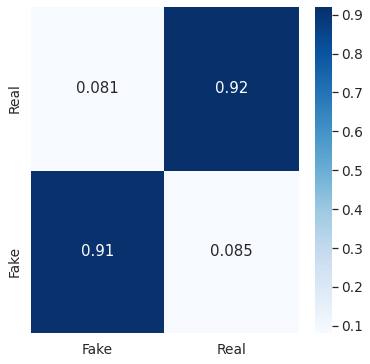

In [ ]:
# Confusion matrix with validation set

val_preds = tuned_nn_updated.predict(val_x).round()

print(classification_report(val_y, val_preds, target_names= ['Fake', 'Real']))
nn_confusion_matrix(val_y, val_preds)

> We're seeing similar accuracy and recall here, so we can make the assumption that this model is performing in a consistent manner.

#### Testing on Single Image



> In order to deploy this model into an app, we want to run several tests to see how the model works with a single image as that is how the app will work.  

In [ ]:
test_file_path = '/Dataset/Validation/Real/real_10001.jpg'
img_class = 1

In [ ]:
test_single_image(test_file_path, tuned_nn_updated, img_class)

The true class of this image is:  1
The predicted class of this images is:  [[1.]]


> The model is properly predicting the correct class of a random image from the validation set, so we could definitely use this model in the final product.  Still, we believe that we can achieve a higher rate of accuracy with other CNN methods so we can continue to explore those.

### CNN with Pretrained Network

> In this model, we experimented with using a pretrained model from Keras.  Keras has several pretrained models that can be used for computer vision.  We settled on the Xception model after our research seemed to point to it being a good starting point for image classification task.  

> Again, in the interest of saving time, we saved the final iteration of this model so it didn't need to train every single time.  You can find the model architecture below and then the results produced from the saved model after that.

#### Model Architecture

``` python
# Early Stopping
callback = EarlyStopping(monitor = 'val_acc', patience = 3, mode = 'max',
                         min_delta = .01, restore_best_weights = True, verbose=2)

# Create model
model_3 = Sequential()

# Create the base with Xception
conv_base = Xception(weights = 'imagenet', include_top = True,
                     classifier_activation = 'softmax')
conv_base.trainable = True
model_3.add(conv_base)

model_3.add(Flatten())

# Add Dense Layers
model_3.add(Dense(256, activation = 'tanh'))
model_3.add(Dense(128, activation = 'tanh'))
model_3.add(Dense(64, activation = 'tanh'))
model_3.add(Dense(32, activation = 'tanh'))
model_3.add(Dense(16, activation = 'tanh'))

# Output layer
model_3.add(Dense(1, activation = 'sigmoid'))

# Compile
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['acc'])

# Get the model summary
print(model_3.summary())

# Fit Model
history_3 = model_3.fit(X_train, y_train, batch_size = 64, epochs = 25,
                    validation_data = (val_x, val_y), callbacks = callback)

# Evaluating the model
evaluate_network(history_3, model_3, X_test, y_test)
```

#### Saved Pretrained Convolutional Neural Network

In [ ]:
# Saving the most current version of the model for later.

drive.mount('/gdrive', force_remount = True)
model_3.save('/gdrive/MyDrive/TrueSight/updated_pretrained_network.keras')


# Saving the history as a dataframe....as a csv

pretrained_hist_df = pd.DataFrame(history_3.history)
drive.mount('/gdrive', force_remount = True)
pretrained_hist_df.to_csv('pretrained_dataframe.csv')
!cp pretrained_dataframe.csv "gdrive/My Drive/TrueSight"


Mounted at /gdrive
Mounted at /gdrive


##### Load & Evaluate Model

Mounted at /gdrive
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 1000)              22910480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None,

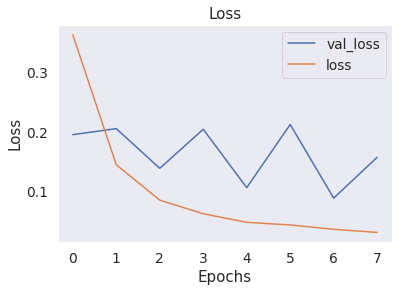

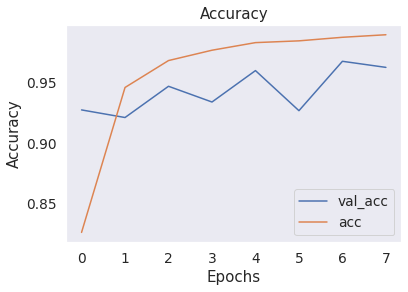

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.96      0.95      0.96     10480
        Real       0.95      0.96      0.96     10270

    accuracy                           0.96     20750
   macro avg       0.96      0.96      0.96     20750
weighted avg       0.96      0.96      0.96     20750

 
                 Confusion Matrix
-------------------------------------------------------


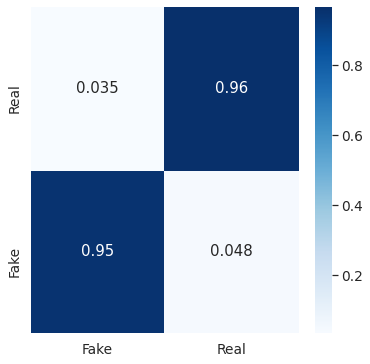

In [ ]:
# Mount google drive again
drive.mount('/gdrive', force_remount = True)

# Loading the ensemble model
pt_network_updated = tf.keras.models.load_model('/gdrive/MyDrive/TrueSight/updated_pretrained_network.keras')

# Loading the model history
history_path2 = 'gdrive/My Drive/TrueSight/pretrained_dataframe.csv'
pretrained_hist_df = pd.read_csv(history_path2)

# Checking the summary
pt_network_updated.summary()

# Evaluate the model
evaluate_network(pretrained_hist_df, pt_network_updated, X_test, y_test)

> The CNN using a pretrained convolutional base was much more accurate, but only after retraining the pretrained convulational base.  Without making the base trainable, the results were actually much much worse than our "home made" model.  The accuracy is great, but massive increase in training time may make this model unrealistic for future deployment.    

#### Testing with Validation Set

> To make sure that we're definitely getting an accurate picture of how the model is performing, we can test it specifically against the validation set.

              precision    recall  f1-score   support

        Fake       0.97      0.95      0.96     10480
        Real       0.95      0.97      0.96     10270

    accuracy                           0.96     20750
   macro avg       0.96      0.96      0.96     20750
weighted avg       0.96      0.96      0.96     20750



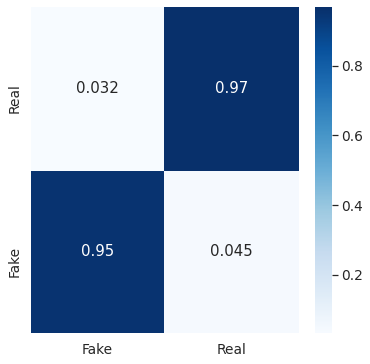

In [ ]:
# Confusion matrix with validation set

pretrained_val_preds = pt_network_updated.predict(val_x).round()

print(classification_report(val_y, pretrained_val_preds, target_names= ['Fake', 'Real']))
nn_confusion_matrix(val_y, pretrained_val_preds)

> Again, the accuracy and recall is similar when testing with the validation set so we are able to assume that the model is performing consistently.

#### Testing on Single Image




> In order to deploy this model into an app, we want to run several tests to see how the model works with a single image as that is how the app will work.  



In [ ]:
test_file_path = '/Dataset/Validation/Real/real_1.jpg'
img_class = 1

In [ ]:
test_single_image(test_file_path, pt_network_updated, img_class)

The true class of this image is:  1
The predicted class of this images is:  [[1.]]


> This model is accuractely predicting the class of a single image, so this can also potentially be used for the final product.  However, the long training time and longer loading time may make this unrealistic.  

#### Model Architecture

In [ ]:
# Reshape Data (to make the model work)
X_train_ensemble = [X_train for _ in range(64)]
X_test_ensemble = [X_test for _ in range(64)]
val_x_ensemble = [val_x for _ in range(64)]

```python
#Model Architecture

models = [tuned_nn_updated, pt_network_updated]
for i, model in enumerate(models):
 for layer in model.layers:
   layer.trainable = False

ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]

#Concatentate
merge = tf.keras.layers.concatenate(ensemble_outputs)

#Early Stopping
callback = EarlyStopping(monitor = 'val_acc', patience = 3, mode = 'max',
                         min_delta = .01, restore_best_weights = True, verbose = 2)

#Add layers
merge = Dense(64, activation = 'relu', name = 'dense_edit')(merge)
output = Dense(1, activation = 'sigmoid', name = 'dense_output')(merge)

ensemble_model = Model(inputs = ensemble_visible, outputs = output)

#Compile
ensemble_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

# Print summary
print(ensemble_model.summary())

# Fit the ensemble
ensemble_history = ensemble_model.fit(X_train_ensemble, y_train, batch_size = 64, epochs = 25,
                   validation_data = (val_x_ensemble, val_y), callbacks = callback)

# Evaluating the model
evaluate_network(ensemble_history, ensemble_model, X_test_ensemble, y_test)

```

#### Saved CNN Ensemble

In [ ]:
#save the most current version of the model

drive.mount('/gdrive', force_remount = True)
ensemble_model.save('/gdrive/MyDrive/TrueSight/updated_ensemble_method.h5')

In [ ]:
# Saving the model history

ensemble_hist_df = pd.DataFrame(ensemble_history.history)
drive.mount('/gdrive', force_remount = True)
ensemble_hist_df.to_csv('ensemble_dataframe.csv')
!cp ensemble_dataframe.csv "gdrive/My Drive/TrueSight"

##### Load & Evaluate the Model

Mounted at /gdrive
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 128)  3584        conv2d_input[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 62, 62, 128)  512         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 128)  0           batch_normalization[0][0]        
____________________________________________________________________

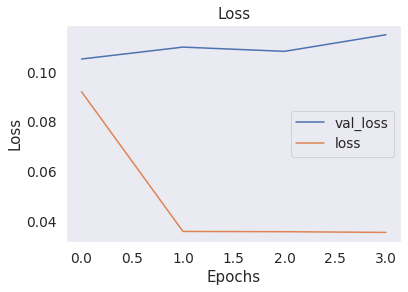

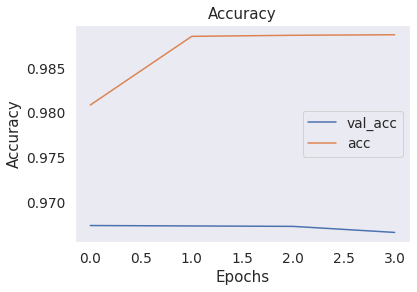

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.97      0.96      0.97     10480
        Real       0.96      0.97      0.96     10270

    accuracy                           0.97     20750
   macro avg       0.97      0.97      0.97     20750
weighted avg       0.97      0.97      0.97     20750

 
                 Confusion Matrix
-------------------------------------------------------


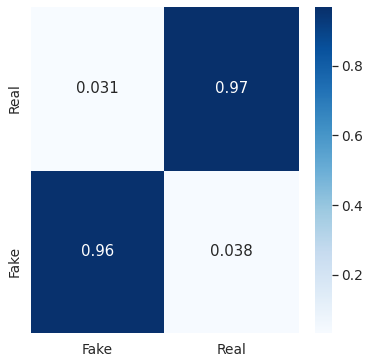

In [ ]:
# Mount google drive again
drive.mount('/gdrive', force_remount = True)

# Loading the ensemble model
ensemble_network = tf.keras.models.load_model('/gdrive/MyDrive/TrueSight/updated_ensemble_method.h5')

# Loading the model history
history_path3 = 'gdrive/My Drive/TrueSight/ensemble_dataframe.csv'
ensemble_hist_df = pd.read_csv(history_path3)

# Checking the summary
ensemble_network.summary()

# Evaluate the model
evaluate_network(ensemble_hist_df, ensemble_network, X_test_ensemble, y_test)

> Using this particular ensemble, there was a 1% boost in accuracy and a slight boost in recall as well.  Given that the data needs to be reshaped in order to make this model work plus the extra training time, we don't feel like it would be worth it to use this model in the final product.

#### Testing with Validation Set


> To make sure that we're definitely getting an accurate picture of how the model is performing, we can test it specifically against the validation set.

              precision    recall  f1-score   support

        Fake       0.97      0.96      0.97     10480
        Real       0.96      0.97      0.97     10270

    accuracy                           0.97     20750
   macro avg       0.97      0.97      0.97     20750
weighted avg       0.97      0.97      0.97     20750



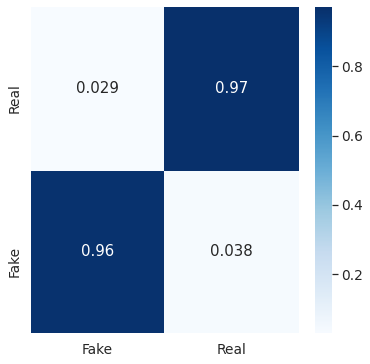

In [ ]:
# Confusion matrix with validation set

ensemble_val_preds = ensemble_network.predict(val_x_ensemble).round()

print(classification_report(val_y, ensemble_val_preds, target_names= ['Fake', 'Real']))
nn_confusion_matrix(val_y, ensemble_val_preds)

#### Testing with Single Image

> In order to deploy this model into an app, we want to run several tests to see how the model works with a single image as that is how the app will work.  

In [ ]:
test_file_path = '/Dataset/Validation/Real/real_10160.jpg'

In [ ]:
test_single_image_ensemble(test_file_path, ensemble_network, img_class)

The true class of this image is:  1
The predicted class of this images is:  [[1.]]


> This model is very accurate and also trains/runs quickly.  This would be great for app deployment, but we do need to figure out how to prep the user input data as the ensemble requires an extra preprocessing step.

## 6. Interpret

> Based on the results of the modeling, we decided on using the CNN that we tuned ourselves as the quicker training time and loading time makes up for the few percentage points of accuracy tha we gain from the other models.  Now that we know that the model is functional, we want to get some insght into how they work.  Below are a few methods of explaining how the CNN is predicting whether an image is real or a deepfake.

### Intermediate Activations

> In order to get a better sense of how the model is working, we can visualize the feature maps generated during training.  Since we know the CNN works by applying a filter in sequence over an image, we can actually see what each iteration of that filter looks like.  

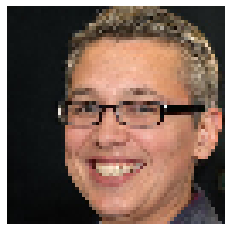

In [ ]:
# Load an image from training set

img_path = '/Dataset/Train/Fake/fake_1000.jpg'

img = image.load_img(img_path, target_size= (64, 64))
plt.axis('off')
plt.imshow(img)
plt.show()

(1, 64, 64, 3)


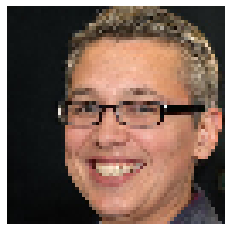

In [ ]:
# Transform to a tensor and visualize

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis= 0)
img_tensor /= 255.

# Check Shape
print(img_tensor.shape)

# Preview Image
plt.axis('off')
plt.imshow(img_tensor[0])
plt.show()

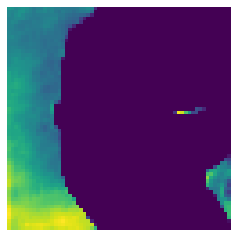

In [ ]:
# Checking out the visual for the first layer of the model

# Getting model layer output
layer_outputs_single = [layer.output for layer in tuned_nn_updated.layers[:8]]

# Make a model to display feature maps
activation_model_single = models.Model(inputs = tuned_nn_updated.input, outputs = layer_outputs_single)

# Get an array for the activation layer
activations_single = activation_model_single.predict(img_tensor)
first_layer_activation = activations_single[0]

# Plot the thing
plt.matshow(first_layer_activation[0, :, :, 3], cmap = 'viridis')
plt.axis('off')
plt.show()

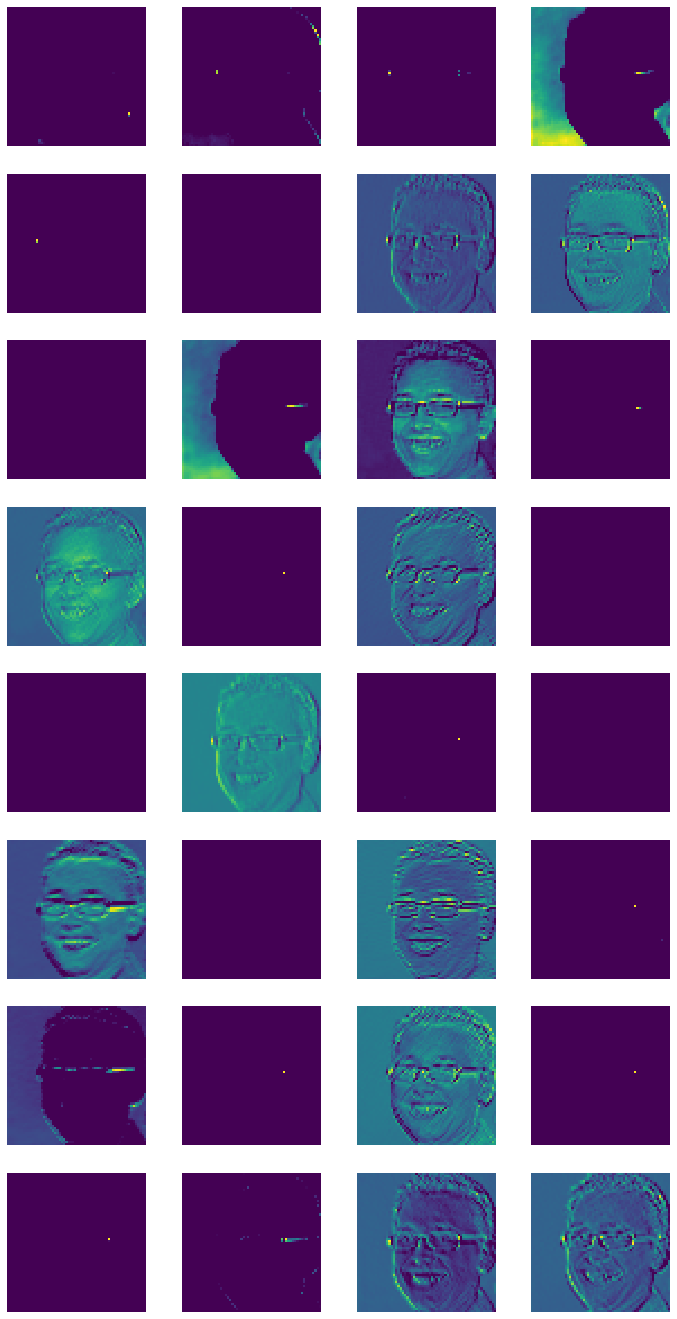

In [ ]:
# Plot out the filters of several layers

fig, axes = plt.subplots(8, 4, figsize=(12,24))

for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.axis('off')
    first_layer_activation = activations_single[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### Lime

> In order to get a more in depth picture of what's happening here, we'll use the Lime Image Explainer to get a deeper insight into how the model is operating.

#### Lime **Architecture**

``` python
# Set up the explainer and segmenter
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments = 100, compactness = 1, sigma = 1)

# Get an explanation for a single image
explanation = explainer.explain_instance(X_test[0], classifier_fn= pt_network_updated,
                                         top_labels = 6, hide_color = 0,
                                         num_samples = 10000,
                                         segmentation_fn = segmenter)

# Plot the explainer
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=5, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.axis('off')
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False)
ax2.axis('off')
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]));

```

#### Plot Lime Function

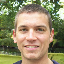

In [ ]:
# Check out a single image before running it through the explainer

array_to_img(X_test[0])

This may take a few minutes...


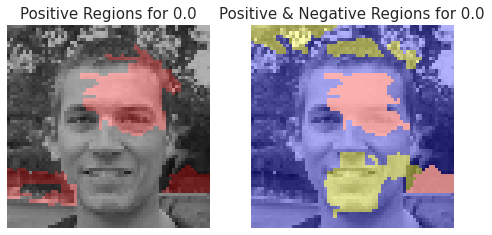

In [ ]:
# Random Images with Lime Explainer

lime_explainer_image(X_test[0], y_test[0])

This may take a few minutes...


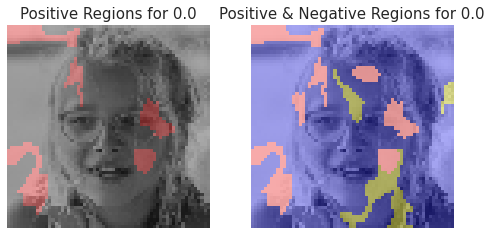

In [ ]:
# Random Images with Lime Explainer

lime_explainer_image(X_test[100], y_test[0])

This may take a few minutes...


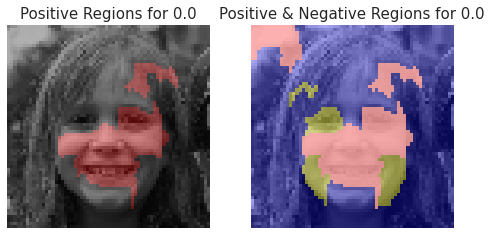

In [ ]:
# Random Images with Lime Explainer

lime_explainer_image(X_test[11900], y_test[0])

This may take a few minutes...


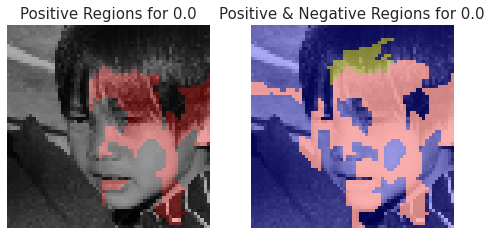

In [ ]:
# Random Images with Lime Explainer

lime_explainer_image(X_test[346], y_test[0])

This may take a few minutes...


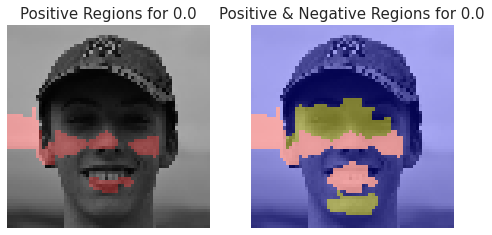

In [ ]:
# Random Images with Lime Explainer

lime_explainer_image(X_test[5426], y_test[0])

> The Lime Explainer provided a really interesting bit of insight into how the model is detecting whether the image is a deepfake.  If you notice, in all the examples that we produced, Lime highlighted at least one of the eyes.  This must mean that the area surrounding the eyes is a main determining factor.

## 7. Conclusion

The technology of image and video editing has made huge leaps in recent years and the emergence of deepfake images have caused serious problems already and have the potential to become more of an issue in the future as the technology improves.  Currently, it's very difficult to tell the difference between a real image and a computer generated deepfake and, in many cases, deepfakes are indecipherable by the naked eye.  

The goal of this project is to develop a system that has the ability to determine whether a given image is either real or a deepfake.  As you can see above, we're not able to trust the naked eye for this task.  Once completed, this deepfake image detection system can be used in many sectors, including social media companies, security organizations and news agencies.

### Results

**After analysing and modeling the data, we have come to the following results:**
 - Convolutional Neural Networks can produce very accurate results for image classification problems.

 - Pretrained neural networks such as Xception are a valuable tool to increase the accuracy of a CNN, but in this case, the paramters need to be retrained which leads to very lengthy training time.  
 - Using an ensemble model yielded slightly better results than a pretrained network and trained much quicker, but the data complications surrounding it and teh fact that previous models need to be trained anyway make it a difficult choice.
 - As far as how the model predicts deepfakes, the Lime Explainer shows that the model tends to focus on the eyes in order to make a determination.  
